# import

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as  plt
import numpy as np

/home/taylor/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
stoi = {chr(97 +i): i+1 for i in range(26)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [5]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':  
            Y.append(stoi[ch])
            X.append(context)
            context = context[1:] + [stoi[ch]]
            # print([itos[x] for x in context], ch)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [6]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:

X, Y = build_dataset(words)

torch.Size([228146, 3]) torch.Size([228146])


# Neural Net

In [8]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [19]:
vocab_size = len(itos)
embed_dim = 10
#block_size = Xtr.shape[1]
hidden_1 = 200


# initialization

In [61]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embed_dim), generator=g)


W1 = torch.randn((block_size * embed_dim, hidden_1), generator=g) * (5/3) / (block_size * embed_dim)**0.5
b1 = torch.randn(hidden_1, generator=g) * 0.01

# it's better not to set the weights at 0. why?
W2 = torch.randn((hidden_1, vocab_size), generator=g)* 1e-2
# we can set the bias at 0
b2 = torch.randn(vocab_size, generator=g)* 0 
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
sum(p.nelement() for p in parameters) # number of parameters in total



11897

### kaiming initialization

In [92]:
fan_in = 10
x = torch.randn(1000, fan_in)
w = torch.randn(fan_in, 200)

In [93]:
y = x @ w 
y.std().item()#, y.mean()

3.1713509559631348

In [96]:
y = x @ w / fan_in**.5
y.std().item()#, y.mean()

1.0028692483901978

In [ ]:
torch.randn(10)

In [103]:
fan_in = 10
x = torch.randn(1000, fan_in)
w = torch.randn(fan_in, 200) * (5/3) / fan_in**0.5

In [104]:
y = torch.tanh(x @ w) 
y.std().item()

0.7477757930755615

In [108]:
w = torch.randn(10000) *(5/3) / fan_in**0.5
w = torch.tanh(w)
w.std()

tensor(0.4297)

# training

In [62]:
lossi = []
stepi = []
loglossi = []

In [63]:
max_steps = 1# 200000
batch_size=32
eval_iters = 1000

for i in range(max_steps):
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward
    emb = C[Xb] # 32, 3, 2
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # hpreact = (hpreact - mu  ) / sigma 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
   # print(loss.item())

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        # lr = lris[i]
        lr = 0.01
        p.data += -lr * p.grad

    if i % eval_iters == 0:    
        print(f"loss {i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.item())

    stepi.append(i)
loss.item()

loss       0/      1: 3.3216


3.321615219116211

In [64]:
- torch.tensor(1/27).log()

tensor(3.2958)

# dead neurons

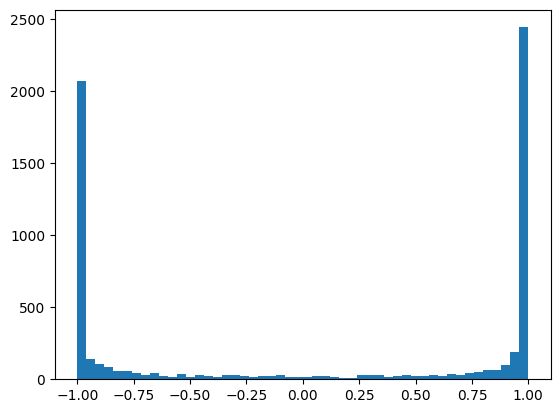

In [65]:
plt.hist(h.view(-1).tolist(), 50);

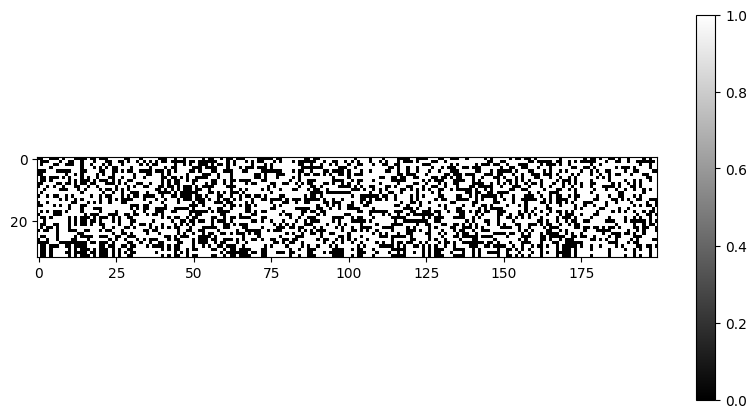

In [67]:
plt.figure(figsize=(10, 5))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.colorbar()

# Evaluating

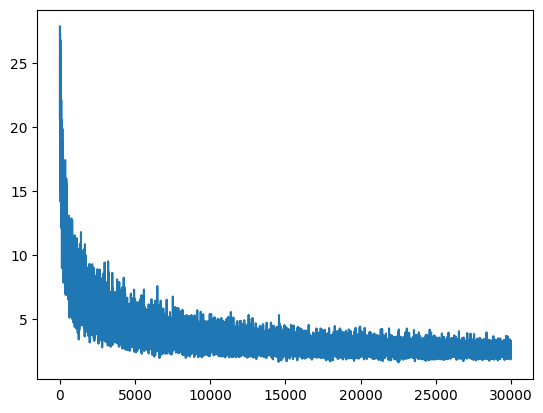

In [15]:
plt.plot(stepi, lossi)

In [14]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')



train 2.5558629035949707
val 2.557117223739624


# Sampling from NN

In [18]:
g = torch.Generator().manual_seed(2147483647 + 10)

for i in range(20):
    out = []
    context = [0] * block_size
    while 1:
        emb = C[torch.tensor(context)] 
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        p = F.softmax(logits, dim=1)
        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        out.append(itos[ix])
        context = context[1:] + [ix]
        if ix == 0:
            break

    print(''.join(out))

row.
jaselde.
maa.
than.
gyil.
mwcaracziaton.
kunle.
ewi.
varo.
audlana.
katdllary.
mabruha.
rion.
del.
rae.
asr.
lavad.
uyya.
abdakynn.
jabnltem.
